**$\Large{Question 1, Part (c)}$**: 

In [36]:
from sympy import DiracDelta
import numpy as np
import seaborn as sns
from termcolor import colored
from numba import jit
import matplotlib.pyplot as plt

In [46]:
@jit
def MembrancePotential(v, w, u0, tau, dt, max_steps, n_simulations):
    
    mp = []
    step = 0
    u = u0
    while step < max_steps:
        
        v_t = v*(1-np.exp(-dt*step)) # v(t) is chosen arbitrarily and v(t)-> v as t->infinity
        y = np.random.normal(0,1)
        u = u + (-u + tau*v_t*w)*dt/tau + np.sqrt(tau*v_t*w**2*dt)*y  # Langevin Equation 
        
        mp.append(u)
        
        step += 1
        
    return mp  

In [51]:
max_steps = 10**7
v = 60
w = 0.01
u0 = 10
tau = 4
dt = 0.01
n_simulations = [1]

simulation = [MembrancePotential(v, w, u0, tau, dt, max_steps, j) for j in n_simulations]

norm_mean = tau*v*w
norm_std = np.sqrt(2)*np.sqrt(tau*v*w**2)
x  = np.random.normal(norm_mean, norm_std, 10000) 

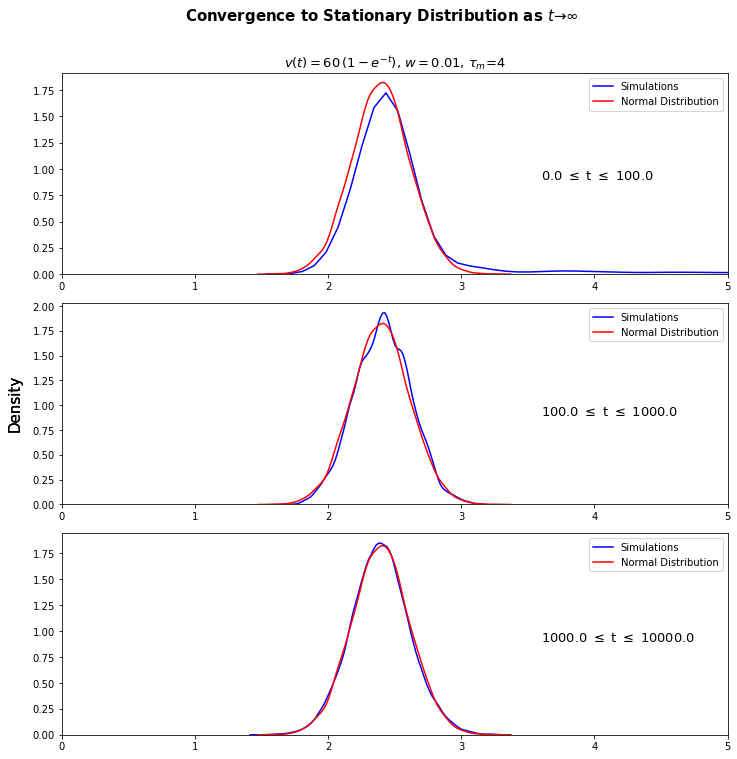

In [52]:

fig, ax = plt.subplots(3,1,figsize=(10,10))

for i in range(3):
    time_slice = [0, 10**4, 10**5, 10**6]
    sns.kdeplot(simulation[0][time_slice[i]:time_slice[i+1]], label='Simulations', ax=ax[i], color='b')
    sns.kdeplot(x, label='Normal Distribution', ax=ax[i], color='r')
    ax[0].set_title(r'$v(t)=60\,(1-e^{-t})$, $w=0.01$, $\tau_{m}$=4', fontsize=13)
    ax[i].text(3.6,0.9, '%1.1f $\leq$ t $\leq$ %1.1f'%(time_slice[i]*dt,time_slice[i+1]*dt), fontsize=13)
    ax[i].legend()
    ax[i].set_xlim([0,5])
    fig.text(-0.02,0.5,'Density', va='center', rotation='vertical', fontsize=15)
    plt.suptitle(r'Convergence to Stationary Distribution as $t \to \infty$', y=1.05, fontsize=15\
                , fontweight='bold')
    plt.tight_layout()




$\;$
$\;$



**$\Large{Question 2}$**:$\;$**In this question we want to find the expected time for leaky integrate and fire neuron to fire and compare to the analytical solution**: 

In [58]:
# Question 2

@jit
def MembrancePotential2(v, w, u0, tau, dt, th1, th2, n_simulations):
    
    step = 0
    u = u0
    
    while True:
        
        y = np.random.normal(0,1)
        u = u + tau*v*w*dt/tau + np.sqrt(tau*v*w**2*dt)*y  
        
        if u >= th2 or u <= th1:
            
            time = step*dt
            break
        
        step += 1
        
    return time 
        

In [59]:
v = 60
w = 0.01
tau = 1
u0 = 0
dt = 0.01
th2 = 1
th1 = -1
simulation = [MembrancePotential2(v, w, u0, tau, dt, th1, th2, j) for j in range(100)]
expected_time = np.mean(simulation)

We compare the result with solution of this ODE:
$$A(x)\frac{\partial }{\partial x} T(x) + 1/2\, B(x)\frac{\partial^{2} }{\partial x^{2}} T(x) = -1$$
with 
$$ T(threshhold_1) = T(threshhold_2) = 0$$
And $A = RI_0 = \tau\,V\,w$ and $B = \tau\,V\,w^{2}$

I have taken $x=0$ and $threshhold_1=-1$ and $threshhold_2=1$ and the solution is :
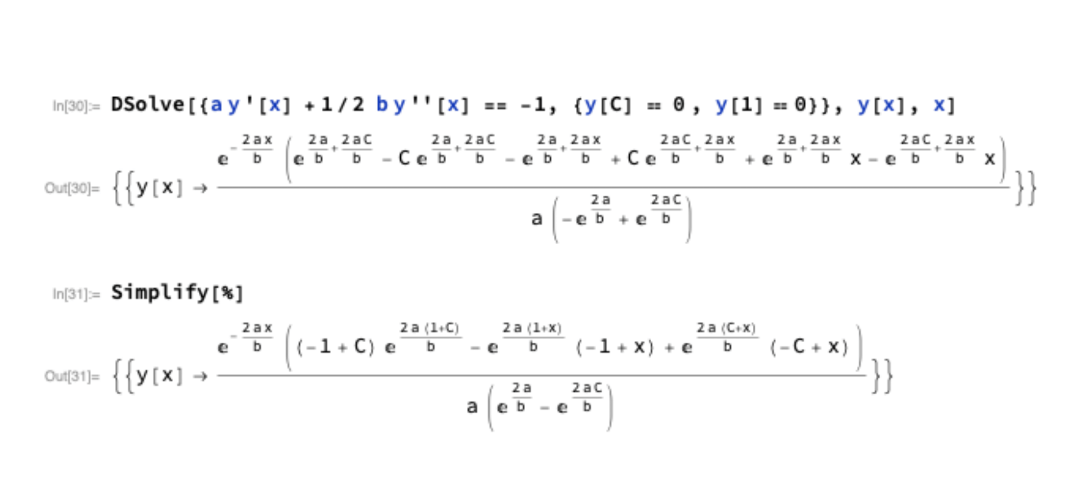

In [60]:
# Solution to ODE and Comparison with simulations
print('Solution to question 2, Example 1:')
a = tau*v*w
b = tau*v*w**2
z = 2*a/b
C = -1
x = 0
y = np.exp(-z*x)*( (-1+C)*np.exp(z*(1+C)) - np.exp(z*(1+x))*(-1+x) + np.exp(z*(C+x))*(-C+x) )/(a*(np.exp(z)-np.exp(z*C)))
print(colored('Analytical Solution for Expected Time =','red'), y)
print(colored('The Simulated Expected Time =','red'), expected_time)

Solution to question 2, Example 1:
Analytical Solution for Expected Time = 1.6666666666666667
The Simulated Expected Time = 1.6637000000000004


In the second example we take $threshhold_1 = -\infty$ and $threshhold_2 = 1$ and will compare the results.

In [61]:
v = 10
w = 0.01
tau = 1
u0 = 0
dt = 0.01
th2 = 1
th1 = -1000000
simulation = [MembrancePotential2(v, w, u0, tau, dt, th1, th2, j) for j in range(100)]
expected_time = np.mean(simulation)

In [63]:
# Solution to ODE and Comparison with simulations
print('Solution to question 2, Example 2:')
a = tau*v*w
b = tau*v*w**2
z = 2*a/b
C = -1000000
x = 0
y = np.exp(-z*x)*( (-1+C)*np.exp(z*(1+C)) - np.exp(z*(1+x))*(-1+x) + np.exp(z*(C+x))*(-C+x) )/(a*(np.exp(z)-np.exp(z*C)))
print(colored('Analytical Solution for Expected Time =','red'), y)
print(colored('The Simulated Expected Time =','red'), expected_time)

Solution to question 2, Example 2:
Analytical Solution for Expected Time = 10.0
The Simulated Expected Time = 10.0942


As we can see again, the solution of ODE is very close to the simulations.


$\;$


**$\Large{Question 5}$**: 

Here we consider this haploid Moran model: 

Assume that for genotype 1 we have these transition probabilities:

$$T(n+1|n) = 0$$
$$T(n-1|n) = \mu_{12}\,n/N$$

where $n/N$ is the frequency of genotype 1 and it mutates to genotype 2 and genotype 2 also mutates to genotype 3 with the rate:

$$V(t) = \mu_{23} \int_{0}^{t} x_{s} ds$$

where $x_t$ is the frequency of genotype 2 at time $t$. We want to find the expected waiting time until genotype 3 is produced.

In the next cell, I have simulated this model.



In [82]:
@jit
def TwoStepAdap2(mu_1, mu_2, N, num_sim):
    
    dt = 0.01
    time = 0
    n1, n2 = N, 0
    n3 = N - n1 - n2
    V = 0
    
    while True:
        
        if np.random.rand() <= mu_1*n1/N*dt:
            n1 -= 1
            n2 += 1
        V += n2/N    
        
        if np.random.rand() <= V*dt:
            hit_time = time*dt
            break
            
        time += 1    
    return hit_time


In [83]:
N = 1000
simulations = {}
print('Solution:')
for i, mu in enumerate([0.1/N, 1/N, 10/N, 0.1/N**2]):
    
    simulations[i] = [TwoStepAdap2(mu, mu, N, j) for j in range(500)]
    expected_time = np.mean(simulations[i]) 
    print(colored(u'Expected waiting time for \u03bc={} is','blue').format(mu),\
                  expected_time,colored('and','blue'), '1/\u03bc={}'.format(1/mu))

Solution:
Expected waiting time for μ=0.0001 is 10583.08188 and 1/μ=10000.0
Expected waiting time for μ=0.001 is 1012.24662 and 1/μ=1000.0
Expected waiting time for μ=0.01 is 94.40248000000001 and 1/μ=100.0
Expected waiting time for μ=1.0000000000000001e-07 is 9343175.75248 and 1/μ=10000000.0
